# * Business Growth Overview

##### *** Compare with VINSIGHT overview : 
- Total Revenue data about 2 days late.
- Target is lower than VINSIGHT (include "TDG" ?)
- %MoM, %WoW is different from VINSIGHT

## Import Data Source
Monitoring Job : 9.00 / 14.00 / 18.00 / 22.00

In [43]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

##### *** "TDG Revenue (Performance View)" or "TDG Revenue (Conso View)" ? : 
- AGG_TYPE = N

In [44]:
as_week = 2023023
# data_src = f"..\data\\raw\Raw-Agg Perf Nationwide_Wk {as_week}.csv"
data_src = f"../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD list '''
prepaid_rev_cd_list = ['B1R000100', 'DB1R000100', 'TB1R000100']
postpaid_rev_cd_list = ['B2R000100', 'DB2R000100', 'TB2R000100']
tol_tvs_tdg_rev_cd_list = ['TB3R000100', 'TB4R000100', 'TNSC00143'] # include "TDG Revenue (Conso View)"
# tol_tvs_tdg_rev_cd_list = ['TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"

bg_rev_all_cd_list = prepaid_rev_cd_list + postpaid_rev_cd_list + tol_tvs_tdg_rev_cd_list
# bg_rev_sum_cd_list = ['DB1R000100', 'TB1R000100', 'DB2R000100', 'TB2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # Exclude : Total of PRE & POST
# bg_rev_sum_cd_list = ['B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"

''' Fix Agg Column Name(Total Revenue) '''
bg_col_list = ['POST_DTAC', 'POST_TMH', 'PRE_DTAC', 'PRE_TMH', 'TOL', 'TVS']

In [45]:
df.shape

(54496, 13)

In [46]:
# ''' Find Metric '''

# # df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
# df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
# df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
# df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]#.reset_index()
# df_metric = pd.concat([df_agg_s, df_agg_n])
# df_metric

# # df_tmp = df_metric[df_metric['METRIC_GRP']=="Revenue"]
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")]#.reset_index()
# # # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()
# # df_tmp = df_tmp[df_tmp['PRODUCT_GRP']=="TVS"]

# # # df_tmp.to_excel('Prepaid_Metric.xlsx')
# # df_tmp

## Data Preporation

In [47]:
''' Rawdata '''

''' Function : Unit Million Baht '''
def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202305] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
df = df[df['TM_KEY_DAY'] <= 20230611] # DAY filter
df = df[df['METRIC_CD'].isin(bg_rev_all_cd_list)]#.reset_index()

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG'})
df.loc[:, 'ACT_SNAP'] = unit_mb(df['ACT_SNAP'])
df.loc[:, 'ACT_AGG'] = unit_mb(df['ACT_AGG'])
df.loc[:, 'TGT_SNAP'] = unit_mb(df['TGT_SNAP'])
df.loc[:, 'TGT_AGG'] = unit_mb(df['TGT_AGG'])

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)
df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,METRIC_CD,METRIC_NAME,AGG_TYPE,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
50124,20230609,2023023,202306,20232,2023,TB4R000100,TVS Revenue,S,NaN,53.222028,NaN,59.556469,2023-06-13 08:49:22,June,23,9
50125,20230610,2023023,202306,20232,2023,TB4R000100,TVS Revenue,S,NaN,53.222028,NaN,59.556469,2023-06-13 08:49:22,June,23,10
50126,20230611,2023023,202306,20232,2023,TB4R000100,TVS Revenue,S,NaN,53.222028,NaN,59.556469,2023-06-13 08:49:22,June,23,11


In [48]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')

In [49]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
# last_wk_tmp = df[['TM_KEY_YR', 'TM_KEY_WK']].drop_duplicates()['TM_KEY_WK'].shift().max()
curr_day = df['TM_KEY_DAY'].max()
last_ppn_tm = df['PPN_TM'].max()

### DAY : Aggregation (base level)

In [50]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG']
df_rev_day = df[cols_agg].reset_index()

''' Aggregation '''
df_rev_day['ACT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['ACT_AGG'], df_rev_day['ACT_SNAP'])
df_rev_day['TGT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['TGT_AGG'], df_rev_day['TGT_SNAP'])
df_rev_day['%ACHV'] = df_rev_day['ACT'] / df_rev_day['TGT']
df_rev_day['GAP'] = df_rev_day['ACT'] - df_rev_day['TGT']
df_rev_day['LAST_ACT'] = df_rev_day.groupby('METRIC_CD')['ACT'].shift()
df_rev_day['DIFF'] = df_rev_day['ACT'] - df_rev_day['LAST_ACT']
df_rev_day['%DOD'] = (df_rev_day['ACT'] / df_rev_day['LAST_ACT']) - 1

df_rev_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,ACT_AGG,TGT_SNAP,TGT_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
924,50124,TB4R000100,TVS Revenue,20230609,2023023,202306,20232,2023,June,9,...,53.222028,NaN,59.556469,NaN,NaN,NaN,NaN,NaN,NaN,NaN
925,50125,TB4R000100,TVS Revenue,20230610,2023023,202306,20232,2023,June,10,...,53.222028,NaN,59.556469,NaN,NaN,NaN,NaN,NaN,NaN,NaN
926,50126,TB4R000100,TVS Revenue,20230611,2023023,202306,20232,2023,June,11,...,53.222028,NaN,59.556469,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
''' Fix Columns Dict '''

cols_dict = {'Postpaid Revenue': 'POST', 'Postpaid Revenue : DTAC': 'POST_DTAC', 'Postpaid Revenue : TMH': 'POST_TMH', 
             'Prepaid Revenue': 'PRE', 'Prepaid Revenue : DTAC': 'PRE_DTAC', 'Prepaid Revenue : TMH': 'PRE_TMH', 
             'TDG Revenue (Conso View)': 'TDG', 'TOL Revenue': 'TOL', 'TVS Revenue': 'TVS'}

In [52]:
''' Pivot by KPIS '''

df_rev_day_agg = df_rev_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index()
df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC  \
METRIC_NAME                                                                 
100           20230609   2023023     202306      20232      2023     June   
101           20230610   2023023     202306      20232      2023     June   
102           20230611   2023023     202306      20232      2023     June   

            DAY_LABEL    ACT_SNAP                         ... DIFF      %DOD  \
METRIC_NAME                  POST  POST_DTAC    POST_TMH  ...  TVS      POST   
100                 9   95.268799  95.268799         NaN  ...  NaN  0.000951   
101                10  559.373631  94.435576  464.938054  ...  NaN  4.871530   
102                11         NaN  90.600177         NaN  ...  NaN       NaN   

                                                                           
METRIC_NAME POST_DTAC POST_TMH       PRE  PRE_DTAC   PRE_TMH  TDG TOL TVS  
100          0.000951      NaN  0.034962  0.023726  0.043440  0.0 NaN NaN  
101         -0.008746      NaN -0.034846 -0.022261 -0.044162  0.0 NaN NaN  
102         -0.040614      NaN       NaN -0.037588       NaN  0.0 NaN NaN  

[3 rows x 70 columns]

In [53]:
''' Add column for BG Summary '''

df_rev_day_agg['ACT_BG'] = df_rev_day_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['TGT_BG'] = df_rev_day_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['%ACHV_BG'] = df_rev_day_agg['ACT_BG'] / df_rev_day_agg['TGT_BG']
df_rev_day_agg['GAP_BG'] = df_rev_day_agg['ACT_BG'] - df_rev_day_agg['TGT_BG']
df_rev_day_agg['LAST_ACT_BG'] = df_rev_day_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['DIFF_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, df_rev_day_agg['ACT_BG']-df_rev_day_agg['LAST_ACT_BG'])
df_rev_day_agg['%DOD_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, (df_rev_day_agg['ACT_BG']/df_rev_day_agg['LAST_ACT_BG'])-1)

df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC  \
METRIC_NAME                                                                 
100           20230609   2023023     202306      20232      2023     June   
101           20230610   2023023     202306      20232      2023     June   
102           20230611   2023023     202306      20232      2023     June   

            DAY_LABEL    ACT_SNAP                         ... %DOD          \
METRIC_NAME                  POST  POST_DTAC    POST_TMH  ...  TDG TOL TVS   
100                 9   95.268799  95.268799         NaN  ...  0.0 NaN NaN   
101                10  559.373631  94.435576  464.938054  ...  0.0 NaN NaN   
102                11         NaN  90.600177         NaN  ...  0.0 NaN NaN   

                 ACT_BG      TGT_BG  %ACHV_BG     GAP_BG LAST_ACT_BG  \
METRIC_NAME                                                            
100          216.977813  214.181772  1.013055   2.796042  212.775798   
101          676.841589  713.667383  0.948399 -36.825794  216.977813   
102          139.317080  147.119185  0.946967  -7.802105  676.841589   

                DIFF_BG   %DOD_BG  
METRIC_NAME                        
100            4.202015  0.019749  
101          459.863776  2.119405  
102         -537.524509 -0.794166  

[3 rows x 77 columns]

## ** Yearly

### YR : Aggregation

In [54]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_rev_yr['%ACHV'] = df_rev_yr['ACT_SNAP'] / df_rev_yr['TGT_SNAP']
df_rev_yr['GAP'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['TGT_SNAP']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACT_SNAP'] / df_rev_yr['LAST_ACT']) - 1

df_rev_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,B1R000100,Prepaid Revenue,2023,S,12257.059219,12264.741072,0.999374,-7.681852,NaN,NaN,NaN
1,B2R000100,Postpaid Revenue,2023,S,22155.010687,22366.512105,0.990544,-211.501419,NaN,NaN,NaN
2,DB1R000100,Prepaid Revenue : DTAC,2023,S,5393.314681,5480.314268,0.984125,-86.999588,NaN,NaN,NaN
3,DB2R000100,Postpaid Revenue : DTAC,2023,S,10015.574725,10190.749304,0.982810,-175.174580,NaN,NaN,NaN
4,TB1R000100,Prepaid Revenue : TMH,2023,S,6912.461441,6835.136926,1.011313,77.324516,NaN,NaN,NaN
5,TB2R000100,Postpaid Revenue : TMH,2023,S,12230.036139,12272.171864,0.996567,-42.135724,NaN,NaN,NaN
6,TB3R000100,TOL Revenue,2023,S,4079.219788,4520.496458,0.902383,-441.276670,NaN,NaN,NaN
7,TB4R000100,TVS Revenue,2023,S,975.266036,1300.405506,0.749971,-325.139470,NaN,NaN,NaN
44920,TNSC00143,TDG Revenue (Conso View),2023,N,256.000000,254.000000,1.007874,2.000000,NaN,NaN,NaN


In [55]:
''' Pivot by KPIS '''

df_rev_yr_agg = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_rev_yr_agg.tail(3)

TM_KEY_YR      ACT_SNAP                                            \
METRIC_NAME                    POST     POST_DTAC      POST_TMH           PRE   
0                2023  22155.010687  10015.574725  12230.036139  12257.059219   

                                                                       ...  \
METRIC_NAME     PRE_DTAC      PRE_TMH    TDG          TOL         TVS  ...   
0            5393.314681  6912.461441  256.0  4079.219788  975.266036  ...   

            DIFF %YOY                                                      
METRIC_NAME  TVS POST POST_DTAC POST_TMH PRE PRE_DTAC PRE_TMH TDG TOL TVS  
0            NaN  NaN       NaN      NaN NaN      NaN     NaN NaN NaN NaN  

[1 rows x 64 columns]

In [56]:
''' Add column for BG Summary '''

df_rev_yr_agg['ACT_BG'] = df_rev_yr_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['TGT_BG'] = df_rev_yr_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['%ACHV_BG'] = df_rev_yr_agg['ACT_BG'] / df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['GAP_BG'] = df_rev_yr_agg['ACT_BG'] - df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['LAST_ACT_BG'] = df_rev_yr_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['DIFF_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, df_rev_yr_agg['ACT_BG']-df_rev_yr_agg['LAST_ACT_BG'])
df_rev_yr_agg['%YOY_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, (df_rev_yr_agg['ACT_BG']/df_rev_yr_agg['LAST_ACT_BG'])-1)

df_rev_yr_agg.tail(3)

TM_KEY_YR      ACT_SNAP                                            \
METRIC_NAME                    POST     POST_DTAC      POST_TMH           PRE   
0                2023  22155.010687  10015.574725  12230.036139  12257.059219   

                                                                       ...  \
METRIC_NAME     PRE_DTAC      PRE_TMH    TDG          TOL         TVS  ...   
0            5393.314681  6912.461441  256.0  4079.219788  975.266036  ...   

            %YOY               ACT_BG        TGT_BG  %ACHV_BG      GAP_BG  \
METRIC_NAME  TDG TOL TVS                                                    
0            NaN NaN NaN  39605.87281  40599.274326  0.975532 -993.401516   

            LAST_ACT_BG DIFF_BG %YOY_BG  
METRIC_NAME                              
0                   0.0     0.0     0.0  

[1 rows x 71 columns]

In [57]:
''' BG Year to Date Values '''

df_last_yr = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==last_yr][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_yr = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_YR']==curr_yr) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# ytd_last_act_tmp = df_last_yr.head(day_cnt_curr_yr)['ACT_BG'].sum()
ytd_last_act = (df_last_yr['ACT_BG'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
ytd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT_BG'].sum()
ytd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TGT_BG'].sum()
ytd_achv = ytd_act / ytd_tgt
ytd_yoy = (ytd_act / ytd_last_act) - 1
ytd_act_gap = ytd_act - ytd_last_act

C:\Users\Narut4\AppData\Local\Temp\ipykernel_15976\801060286.py:6: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_act = (df_last_yr['ACT_BG'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr


In [58]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' Actual '''
y_yr_act = df_rev_yr_agg['ACT_BG']
y_yr_act_post = df_rev_yr_agg['ACT_SNAP']['POST']
y_yr_act_post_dtac = df_rev_yr_agg['ACT_SNAP']['POST_DTAC']
y_yr_act_post_tmh = df_rev_yr_agg['ACT_SNAP']['POST_TMH']
y_yr_act_pre = df_rev_yr_agg['ACT_SNAP']['PRE']
y_yr_act_pre_dtac = df_rev_yr_agg['ACT_SNAP']['PRE_DTAC']
y_yr_act_pre_tmh = df_rev_yr_agg['ACT_SNAP']['PRE_TMH']
y_yr_act_tdg = df_rev_yr_agg['ACT_SNAP']['TDG']
y_yr_act_tol = df_rev_yr_agg['ACT_SNAP']['TOL']
y_yr_act_tvs = df_rev_yr_agg['ACT_SNAP']['TVS']

''' Target '''
y_yr_tgt = df_rev_yr_agg['TGT_BG']
y_yr_tgt_post = df_rev_yr_agg['TGT_SNAP']['POST']
y_yr_tgt_post_dtac = df_rev_yr_agg['TGT_SNAP']['POST_DTAC']
y_yr_tgt_post_tmh = df_rev_yr_agg['TGT_SNAP']['POST_TMH']
y_yr_tgt_pre = df_rev_yr_agg['TGT_SNAP']['PRE']
y_yr_tgt_pre_dtac = df_rev_yr_agg['TGT_SNAP']['PRE_DTAC']
y_yr_tgt_pre_tmh = df_rev_yr_agg['TGT_SNAP']['PRE_TMH']
y_yr_tgt_tdg = df_rev_yr_agg['TGT_SNAP']['TDG']
y_yr_tgt_tol = df_rev_yr_agg['TGT_SNAP']['TOL']
y_yr_tgt_tvs = df_rev_yr_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_yr_achv = df_rev_yr_agg['%ACHV_BG']
y_yr_achv_post = df_rev_yr_agg['%ACHV']['POST']
y_yr_achv_post_dtac = df_rev_yr_agg['%ACHV']['POST_DTAC']
y_yr_achv_post_tmh = df_rev_yr_agg['%ACHV']['POST_TMH']
y_yr_achv_pre = df_rev_yr_agg['%ACHV']['PRE']
y_yr_achv_pre_dtac = df_rev_yr_agg['%ACHV']['PRE_DTAC']
y_yr_achv_pre_tmh = df_rev_yr_agg['%ACHV']['PRE_TMH']
y_yr_achv_tdg = df_rev_yr_agg['%ACHV']['TDG']
y_yr_achv_tol = df_rev_yr_agg['%ACHV']['TOL']
y_yr_achv_tvs = df_rev_yr_agg['%ACHV']['TVS']

''' Gap '''
y_yr_gap = df_rev_yr_agg['GAP_BG']
y_yr_gap_post = df_rev_yr_agg['GAP']['POST']
y_yr_gap_post_dtac = df_rev_yr_agg['GAP']['POST_DTAC']
y_yr_gap_post_tmh = df_rev_yr_agg['GAP']['POST_TMH']
y_yr_gap_pre = df_rev_yr_agg['GAP']['PRE']
y_yr_gap_pre_dtac = df_rev_yr_agg['GAP']['PRE_DTAC']
y_yr_gap_pre_tmh = df_rev_yr_agg['GAP']['PRE_TMH']
y_yr_gap_tdg = df_rev_yr_agg['GAP']['TDG']
y_yr_gap_tol = df_rev_yr_agg['GAP']['TOL']
y_yr_gap_tvs = df_rev_yr_agg['GAP']['TVS']

''' Last Actual '''
y_yr_last_act = df_rev_yr_agg['LAST_ACT_BG']
y_yr_last_act_post = df_rev_yr_agg['LAST_ACT']['POST']
y_yr_last_act_post_dtac = df_rev_yr_agg['LAST_ACT']['POST_DTAC']
y_yr_last_act_post_tmh = df_rev_yr_agg['LAST_ACT']['POST_TMH']
y_yr_last_act_pre = df_rev_yr_agg['LAST_ACT']['PRE']
y_yr_last_act_pre_dtac = df_rev_yr_agg['LAST_ACT']['PRE_DTAC']
y_yr_last_act_pre_tmh = df_rev_yr_agg['LAST_ACT']['PRE_TMH']
y_yr_last_act_tdg = df_rev_yr_agg['LAST_ACT']['TDG']
y_yr_last_act_tol = df_rev_yr_agg['LAST_ACT']['TOL']
y_yr_last_act_tvs = df_rev_yr_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_yr_diff = df_rev_yr_agg['DIFF_BG']
y_yr_diff_post = df_rev_yr_agg['DIFF']['POST']
y_yr_diff_post_dtac = df_rev_yr_agg['DIFF']['POST_DTAC']
y_yr_diff_post_tmh = df_rev_yr_agg['DIFF']['POST_TMH']
y_yr_diff_pre = df_rev_yr_agg['DIFF']['PRE']
y_yr_diff_pre_dtac = df_rev_yr_agg['DIFF']['PRE_DTAC']
y_yr_diff_pre_tmh = df_rev_yr_agg['DIFF']['PRE_TMH']
y_yr_diff_tdg = df_rev_yr_agg['DIFF']['TDG']
y_yr_diff_tol = df_rev_yr_agg['DIFF']['TOL']
y_yr_diff_tvs = df_rev_yr_agg['DIFF']['TVS']

''' % YOY '''
y_yr_yoy = df_rev_yr_agg['%YOY_BG']
y_yr_yoy_post = df_rev_yr_agg['%YOY']['POST']
y_yr_yoy_post_dtac = df_rev_yr_agg['%YOY']['POST_DTAC']
y_yr_yoy_post_tmh = df_rev_yr_agg['%YOY']['POST_TMH']
y_yr_yoy_pre = df_rev_yr_agg['%YOY']['PRE']
y_yr_yoy_pre_dtac = df_rev_yr_agg['%YOY']['PRE_DTAC']
y_yr_yoy_pre_tmh = df_rev_yr_agg['%YOY']['PRE_TMH']
y_yr_yoy_tdg = df_rev_yr_agg['%YOY']['TDG']
y_yr_yoy_tol = df_rev_yr_agg['%YOY']['TOL']
y_yr_yoy_tvs = df_rev_yr_agg['%YOY']['TVS']

### YR : Business Growth Revenue Summary

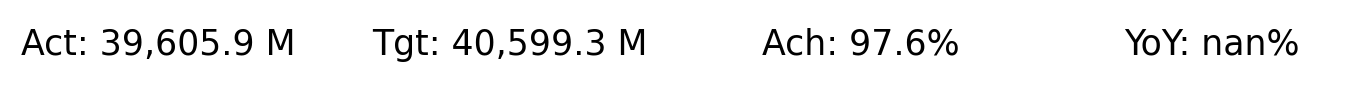

In [59]:
''' Yearly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(ytd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(ytd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

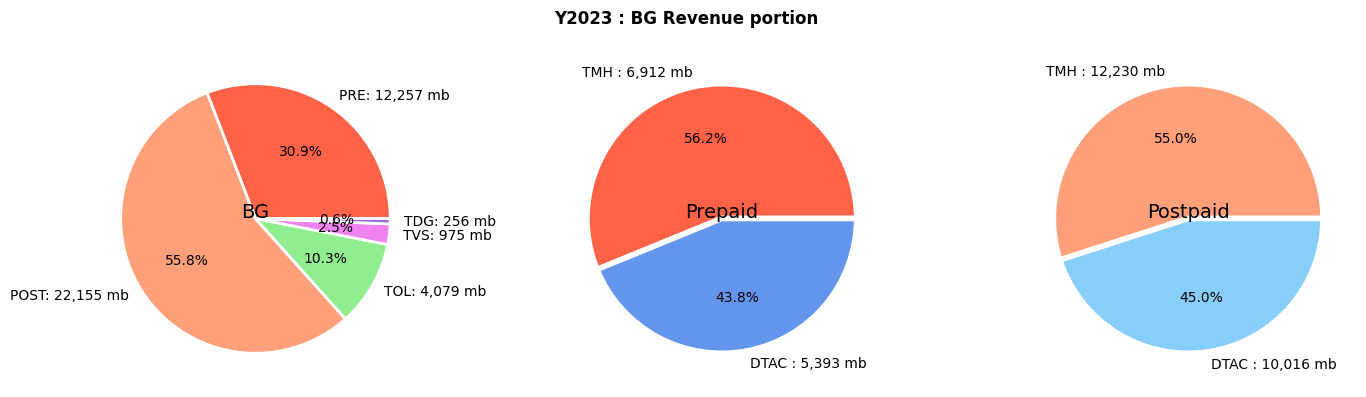

In [60]:
''' Revenue Portion Chart '''

fig = plt.figure(figsize=(14.3, 4))
fig.suptitle(f'Y{curr_yr} : BG Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([y_yr_act_pre.sum(), y_yr_act_post.sum(), y_yr_act_tol.sum(), y_yr_act_tvs.sum(), y_yr_act_tdg.sum()])
mylabels = [f"PRE: {format(y[0],',.0f')} mb", f"POST: {format(y[1],',.0f')} mb", f"TOL: {format(y[2],',.0f')} mb", f"TVS: {format(y[3],',.0f')} mb", f"TDG: {format(y[4],',.0f')} mb"]
mycolors = ["tomato", "lightsalmon", "lightgreen", "violet",  "mediumpurple"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 2, "edgecolor": "white"})
ax1.text(0, 0, 'BG', ha='center', fontsize=14)

''' ax2 '''
y = np.array([y_yr_act_pre_tmh.sum(), y_yr_act_pre_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["tomato", "cornflowerblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'Prepaid', ha='center', fontsize=14)

''' ax3 '''
y = np.array([y_yr_act_post_tmh.sum(), y_yr_act_post_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["lightsalmon", "lightskyblue"]
ax3.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax3.text(0, 0, 'Postpaid', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

## ** Monthly

### MTH : Aggregation

In [61]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_rev_mth['%ACHV'] = df_rev_mth['ACT_SNAP'] / df_rev_mth['TGT_SNAP']
df_rev_mth['GAP'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['TGT_SNAP']
df_rev_mth['LAST_ACT'] = df_rev_mth.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_mth['DIFF'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['LAST_ACT']
df_rev_mth['%MOM'] = (df_rev_mth['ACT_SNAP'] / df_rev_mth['LAST_ACT']) - 1

df_rev_mth.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%MOM
31,TB4R000100,TVS Revenue,202306,June,S,53.222028,59.556469,0.893640,-6.334440,376.219863,-322.997835,-0.858535
44850,TNSC00143,TDG Revenue (Conso View),202303,March,N,237.292177,288.000000,0.823931,-50.707823,NaN,NaN,NaN
44878,TNSC00143,TDG Revenue (Conso View),202304,April,N,201.594666,295.000000,0.683372,-93.405334,237.292177,-35.697511,-0.150437
44913,TNSC00143,TDG Revenue (Conso View),202305,May,N,252.000000,278.000000,0.906475,-26.000000,201.594666,50.405334,0.250033
44920,TNSC00143,TDG Revenue (Conso View),202306,June,N,256.000000,254.000000,1.007874,2.000000,252.000000,4.000000,0.015873


In [62]:
''' Pivot by KPIS '''

df_rev_mth_agg = df_rev_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_rev_mth_agg.tail(3)

TM_KEY_MTH MTH_DESC     ACT_SNAP                            \
METRIC_NAME                             POST    POST_DTAC     POST_TMH   
1               202304    April  6654.114487  2960.554432  3693.560055   
2               202305      May  6582.670122  2953.069229  3629.600893   
3               202306     June  2315.085281  1118.062596  1287.622863   

                                                                             \
METRIC_NAME          PRE     PRE_DTAC      PRE_TMH         TDG          TOL   
1            3584.677321  1569.575558  2015.101763  201.594666  1405.515708   
2            3733.741967  1610.280929  2123.461039  252.000000  1272.301320   
3            1255.082316   593.216882   710.582337  256.000000     0.000000   

             ...        DIFF      %MOM                                \
METRIC_NAME  ...         TVS      POST POST_DTAC  POST_TMH       PRE   
1            ...    1.566500  0.007720 -0.007820  0.020531 -0.026844   
2            ...  102.524541 -0.010737 -0.002528 -0.017316  0.041584   
3            ... -322.997835 -0.648306 -0.621390 -0.645244 -0.663854   

                                                               
METRIC_NAME  PRE_DTAC   PRE_TMH       TDG       TOL       TVS  
1           -0.031270 -0.023367 -0.150437  0.002935  0.005756  
2            0.025934  0.053774  0.250033 -0.094780  0.374594  
3           -0.631607 -0.665366  0.015873 -1.000000 -0.858535  

[3 rows x 65 columns]

In [63]:
''' Add column for BG Summary '''

df_rev_mth_agg['ACT_BG'] = df_rev_mth_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['TGT_BG'] = df_rev_mth_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['%ACHV_BG'] = df_rev_mth_agg['ACT_BG'] / df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['GAP_BG'] = df_rev_mth_agg['ACT_BG'] - df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['LAST_ACT_BG'] = df_rev_mth_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['DIFF_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, df_rev_mth_agg['ACT_BG']-df_rev_mth_agg['LAST_ACT_BG'])
df_rev_mth_agg['%MOM_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, (df_rev_mth_agg['ACT_BG']/df_rev_mth_agg['LAST_ACT_BG'])-1)

df_rev_mth_agg.tail(3)

TM_KEY_MTH MTH_DESC     ACT_SNAP                            \
METRIC_NAME                             POST    POST_DTAC     POST_TMH   
1               202304    April  6654.114487  2960.554432  3693.560055   
2               202305      May  6582.670122  2953.069229  3629.600893   
3               202306     June  2315.085281  1118.062596  1287.622863   

                                                                             \
METRIC_NAME          PRE     PRE_DTAC      PRE_TMH         TDG          TOL   
1            3584.677321  1569.575558  2015.101763  201.594666  1405.515708   
2            3733.741967  1610.280929  2123.461039  252.000000  1272.301320   
3            1255.082316   593.216882   710.582337  256.000000     0.000000   

             ...      %MOM                            ACT_BG        TGT_BG  \
METRIC_NAME  ...       TDG       TOL       TVS                               
1            ... -0.150437  0.002935  0.005756  11918.002837  12232.510932   
2            ...  0.250033 -0.094780  0.374594  11964.933273  12243.253305   
3            ...  0.015873 -1.000000 -0.858535   3762.706706   3851.963825   

             %ACHV_BG      GAP_BG   LAST_ACT_BG      DIFF_BG   %MOM_BG  
METRIC_NAME                                                             
1            0.974289 -314.508095  11960.229993   -42.227156 -0.003531  
2            0.977267 -278.320031  11918.002837    46.930436  0.003938  
3            0.976828  -89.257119  11964.933273 -8202.226568 -0.685522  

[3 rows x 72 columns]

In [64]:
''' BG Month to Date Values '''

df_last_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_mth = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_MTH']==curr_mth) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# mtd_last_act_tmp = df_last_mth.head(day_cnt_curr_mth)['ACT_BG'].sum()
mtd_last_act = (df_last_mth['ACT_BG'].sum() / len(df_last_mth['TM_KEY_DAY'].unique())) * day_cnt_curr_mth
mtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['ACT_BG'].sum()
mtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TGT_BG'].sum()
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / mtd_last_act) - 1
mtd_act_gap = mtd_act - mtd_last_act

In [65]:
''' Month Chart Values '''

x_mth = df_rev_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' Actual '''
y_mth_act = df_rev_mth_agg['ACT_BG']
y_mth_act_post = df_rev_mth_agg['ACT_SNAP']['POST']
y_mth_act_post_dtac = df_rev_mth_agg['ACT_SNAP']['POST_DTAC']
y_mth_act_post_tmh = df_rev_mth_agg['ACT_SNAP']['POST_TMH']
y_mth_act_pre = df_rev_mth_agg['ACT_SNAP']['PRE']
y_mth_act_pre_dtac = df_rev_mth_agg['ACT_SNAP']['PRE_DTAC']
y_mth_act_pre_tmh = df_rev_mth_agg['ACT_SNAP']['PRE_TMH']
y_mth_act_tdg = df_rev_mth_agg['ACT_SNAP']['TDG']
y_mth_act_tol = df_rev_mth_agg['ACT_SNAP']['TOL']
y_mth_act_tvs = df_rev_mth_agg['ACT_SNAP']['TVS']

''' Target '''
y_mth_tgt = df_rev_mth_agg['TGT_BG']
y_mth_tgt_post = df_rev_mth_agg['TGT_SNAP']['POST']
y_mth_tgt_post_dtac = df_rev_mth_agg['TGT_SNAP']['POST_DTAC']
y_mth_tgt_post_tmh = df_rev_mth_agg['TGT_SNAP']['POST_TMH']
y_mth_tgt_pre = df_rev_mth_agg['TGT_SNAP']['PRE']
y_mth_tgt_pre_dtac = df_rev_mth_agg['TGT_SNAP']['PRE_DTAC']
y_mth_tgt_pre_tmh = df_rev_mth_agg['TGT_SNAP']['PRE_TMH']
y_mth_tgt_tdg = df_rev_mth_agg['TGT_SNAP']['TDG']
y_mth_tgt_tol = df_rev_mth_agg['TGT_SNAP']['TOL']
y_mth_tgt_tvs = df_rev_mth_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_mth_achv = df_rev_mth_agg['%ACHV_BG']
y_mth_achv_post = df_rev_mth_agg['%ACHV']['POST']
y_mth_achv_post_dtac = df_rev_mth_agg['%ACHV']['POST_DTAC']
y_mth_achv_post_tmh = df_rev_mth_agg['%ACHV']['POST_TMH']
y_mth_achv_pre = df_rev_mth_agg['%ACHV']['PRE']
y_mth_achv_pre_dtac = df_rev_mth_agg['%ACHV']['PRE_DTAC']
y_mth_achv_pre_tmh = df_rev_mth_agg['%ACHV']['PRE_TMH']
y_mth_achv_tdg = df_rev_mth_agg['%ACHV']['TDG']
y_mth_achv_tol = df_rev_mth_agg['%ACHV']['TOL']
y_mth_achv_tvs = df_rev_mth_agg['%ACHV']['TVS']

''' Gap '''
y_mth_gap = df_rev_mth_agg['GAP_BG']
y_mth_gap_post = df_rev_mth_agg['GAP']['POST']
y_mth_gap_post_dtac = df_rev_mth_agg['GAP']['POST_DTAC']
y_mth_gap_post_tmh = df_rev_mth_agg['GAP']['POST_TMH']
y_mth_gap_pre = df_rev_mth_agg['GAP']['PRE']
y_mth_gap_pre_dtac = df_rev_mth_agg['GAP']['PRE_DTAC']
y_mth_gap_pre_tmh = df_rev_mth_agg['GAP']['PRE_TMH']
y_mth_gap_tdg = df_rev_mth_agg['GAP']['TDG']
y_mth_gap_tol = df_rev_mth_agg['GAP']['TOL']
y_mth_gap_tvs = df_rev_mth_agg['GAP']['TVS']

''' Last Actual '''
y_mth_last_act = df_rev_mth_agg['LAST_ACT_BG']
y_mth_last_act_post = df_rev_mth_agg['LAST_ACT']['POST']
y_mth_last_act_post_dtac = df_rev_mth_agg['LAST_ACT']['POST_DTAC']
y_mth_last_act_post_tmh = df_rev_mth_agg['LAST_ACT']['POST_TMH']
y_mth_last_act_pre = df_rev_mth_agg['LAST_ACT']['PRE']
y_mth_last_act_pre_dtac = df_rev_mth_agg['LAST_ACT']['PRE_DTAC']
y_mth_last_act_pre_tmh = df_rev_mth_agg['LAST_ACT']['PRE_TMH']
y_mth_last_act_tdg = df_rev_mth_agg['LAST_ACT']['TDG']
y_mth_last_act_tol = df_rev_mth_agg['LAST_ACT']['TOL']
y_mth_last_act_tvs = df_rev_mth_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_mth_diff = df_rev_mth_agg['DIFF_BG']
y_mth_diff_post = df_rev_mth_agg['DIFF']['POST']
y_mth_diff_post_dtac = df_rev_mth_agg['DIFF']['POST_DTAC']
y_mth_diff_post_tmh = df_rev_mth_agg['DIFF']['POST_TMH']
y_mth_diff_pre = df_rev_mth_agg['DIFF']['PRE']
y_mth_diff_pre_dtac = df_rev_mth_agg['DIFF']['PRE_DTAC']
y_mth_diff_pre_tmh = df_rev_mth_agg['DIFF']['PRE_TMH']
y_mth_diff_tdg = df_rev_mth_agg['DIFF']['TDG']
y_mth_diff_tol = df_rev_mth_agg['DIFF']['TOL']
y_mth_diff_tvs = df_rev_mth_agg['DIFF']['TVS']

''' % MOM '''
y_mth_mom = df_rev_mth_agg['%MOM_BG']
y_mth_mom_post = df_rev_mth_agg['%MOM']['POST']
y_mth_mom_post_dtac = df_rev_mth_agg['%MOM']['POST_DTAC']
y_mth_mom_post_tmh = df_rev_mth_agg['%MOM']['POST_TMH']
y_mth_mom_pre = df_rev_mth_agg['%MOM']['PRE']
y_mth_mom_pre_dtac = df_rev_mth_agg['%MOM']['PRE_DTAC']
y_mth_mom_pre_tmh = df_rev_mth_agg['%MOM']['PRE_TMH']
y_mth_mom_tdg = df_rev_mth_agg['%MOM']['TDG']
y_mth_mom_tol = df_rev_mth_agg['%MOM']['TOL']
y_mth_mom_tvs = df_rev_mth_agg['%MOM']['TVS']

### MTH : Business Growth Revenue Summary

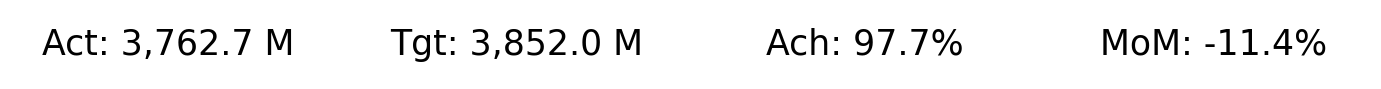

In [66]:
''' Monthly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(mtd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(mtd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

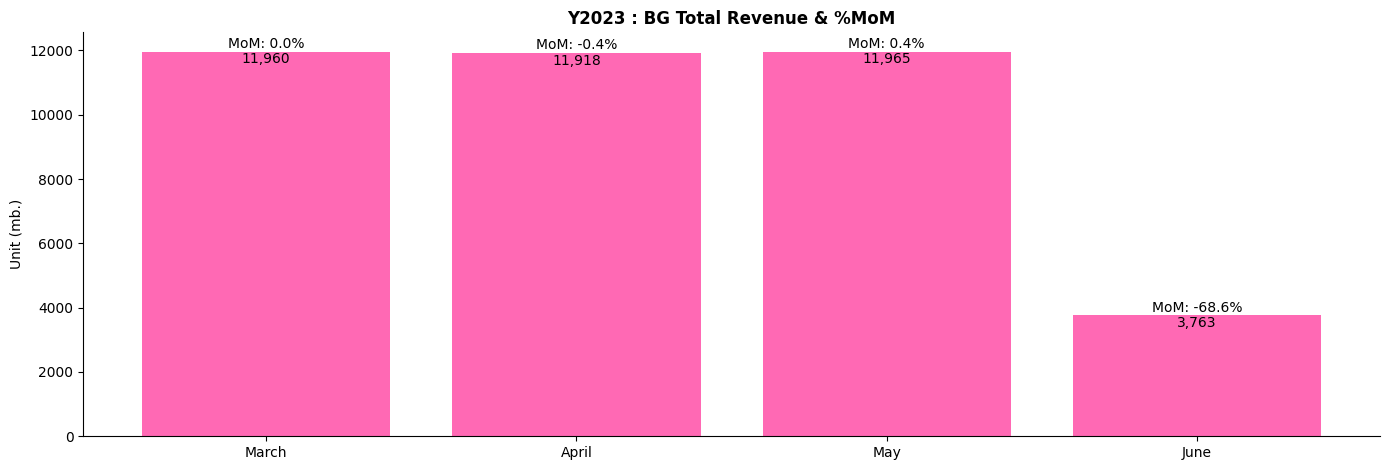

In [67]:
''' Total Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Total Revenue & %MoM", weight='bold')
plt.bar(x_mth_axis, y_mth_act, label='Total', color='hotpink')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_mth_act[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-20), ha='center', va='top')

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
# plt.legend()
plt.tight_layout()
plt.show()

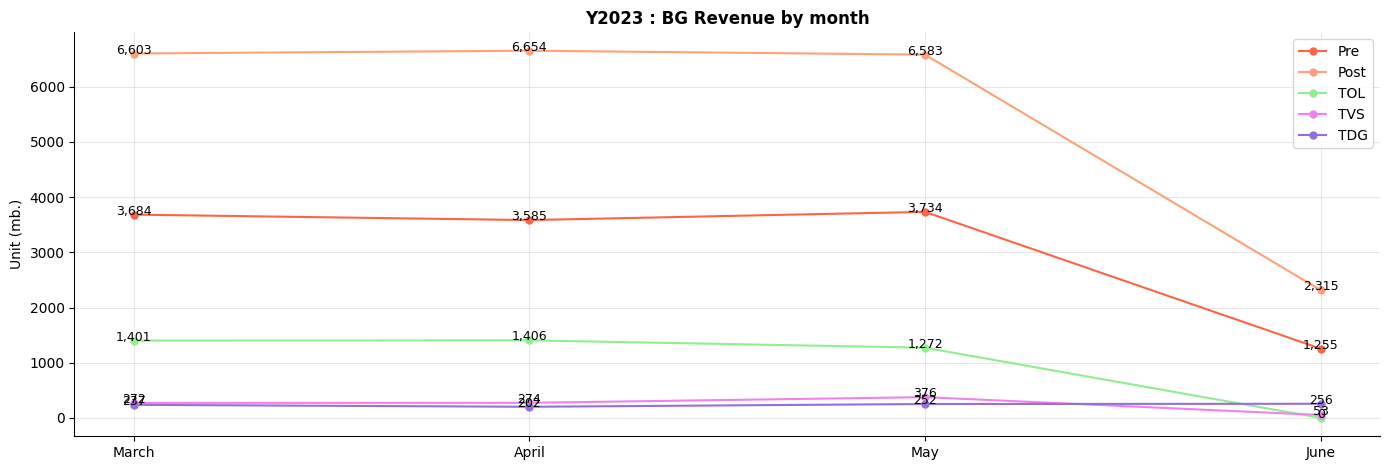

In [68]:
''' Revenue : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Revenue by month", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_mth_axis, y_mth_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_mth_axis, y_mth_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_post[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tdg[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tdg[i]), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

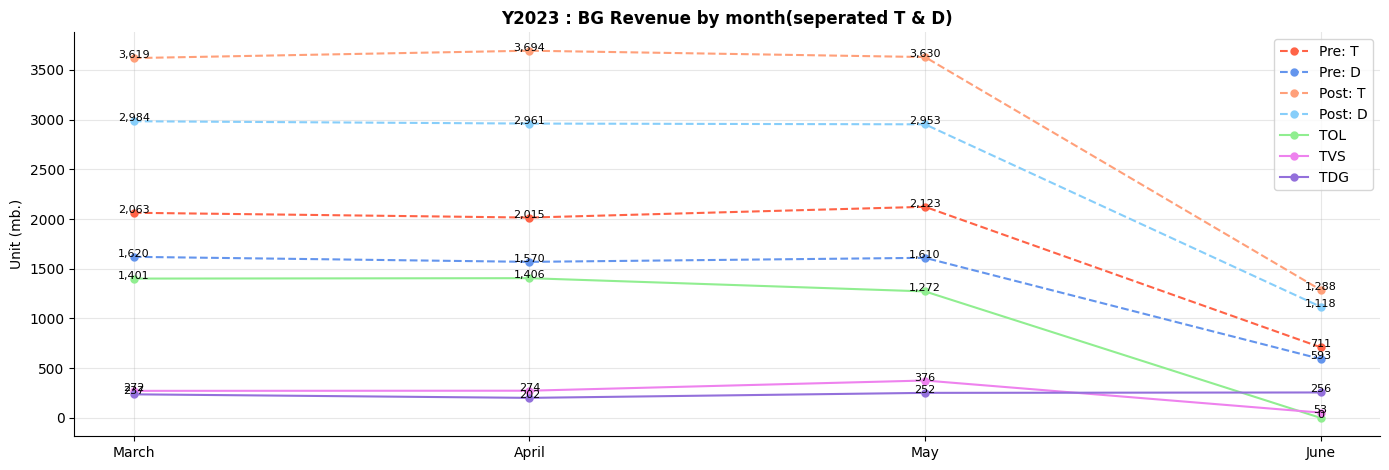

In [69]:
''' Revenue(Mobile separated by TMH, DTAC) : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Revenue by month(seperated T & D)", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_mth_axis, y_mth_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_mth_axis, y_mth_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_mth_axis, y_mth_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_pre_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tdg[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ** Weekly

### WK : Aggregation

In [70]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

# ''' Aggregation '''
df_rev_wk['%ACHV'] = df_rev_wk['ACT_SNAP'] / df_rev_wk['TGT_SNAP']
df_rev_wk['GAP'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['TGT_SNAP']
df_rev_wk['LAST_ACT'] = df_rev_wk.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_wk['DIFF'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['LAST_ACT']
df_rev_wk['%WOW'] = (df_rev_wk['ACT_SNAP'] / df_rev_wk['LAST_ACT']) - 1

df_rev_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%WOW
44906,TNSC00143,TDG Revenue (Conso View),2023021,21,N,258.0,278.0,0.928058,-20.0,258.0,0.0,0.000000
44913,TNSC00143,TDG Revenue (Conso View),2023022,22,N,252.0,278.0,0.906475,-26.0,258.0,-6.0,-0.023256
44920,TNSC00143,TDG Revenue (Conso View),2023023,23,N,256.0,254.0,1.007874,2.0,252.0,4.0,0.015873


In [71]:
''' Pivot by KPIS '''

df_rev_wk_agg = df_rev_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_rev_wk_agg.tail(3)

TM_KEY_WK WK_LABEL     ACT_SNAP                           \
METRIC_NAME                            POST   POST_DTAC     POST_TMH   
12            2023021       21  1749.401712  639.606530  1109.795181   
13            2023022       22  1364.050335  764.967575   599.082759   
14            2023023       23  1269.929023  664.625420   695.903781   

                                                                    ...  \
METRIC_NAME         PRE    PRE_DTAC     PRE_TMH    TDG         TOL  ...   
12           817.699159  350.000495  467.698664  258.0  300.254581  ...   
13           942.800527  402.414983  540.385544  252.0    0.000000  ...   
14           721.850541  361.158725  409.408719  256.0    0.000000  ...   

                   DIFF      %WOW                                          \
METRIC_NAME         TVS      POST POST_DTAC  POST_TMH       PRE  PRE_DTAC   
12            26.359556  0.281275  0.033302  0.486929  0.009918  0.001050   
13            88.631325 -0.220276  0.195997 -0.460186  0.152992  0.149755   
14          -156.321268 -0.069001 -0.131172  0.161615 -0.234355 -0.102522   

                                                     
METRIC_NAME   PRE_TMH       TDG       TOL       TVS  
12           0.016658  0.000000 -0.021376  0.496167  
13           0.155414 -0.023256 -1.000000  1.115057  
14          -0.242377  0.015873       NaN -0.929835  

[3 rows x 65 columns]

In [72]:
''' Add column for BG Summary '''

df_rev_wk_agg['ACT_BG'] = df_rev_wk_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['TGT_BG'] = df_rev_wk_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['%ACHV_BG'] = df_rev_wk_agg['ACT_BG'] / df_rev_wk_agg['TGT_BG']
df_rev_wk_agg['GAP_BG'] = df_rev_wk_agg['ACT_BG'] - df_rev_wk_agg['TGT_BG']
df_rev_wk_agg['LAST_ACT_BG'] = df_rev_wk_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['DIFF_BG'] = np.where(df_rev_wk_agg['LAST_ACT_BG']<=0, 0, df_rev_wk_agg['ACT_BG']-df_rev_wk_agg['LAST_ACT_BG'])
df_rev_wk_agg['%WOW_BG'] = np.where(df_rev_wk_agg['LAST_ACT_BG']<=0, 0, (df_rev_wk_agg['ACT_BG']/df_rev_wk_agg['LAST_ACT_BG'])-1)

df_rev_wk_agg.tail(3)

TM_KEY_WK WK_LABEL     ACT_SNAP                           \
METRIC_NAME                            POST   POST_DTAC     POST_TMH   
12            2023021       21  1749.401712  639.606530  1109.795181   
13            2023022       22  1364.050335  764.967575   599.082759   
14            2023023       23  1269.929023  664.625420   695.903781   

                                                                    ...  \
METRIC_NAME         PRE    PRE_DTAC     PRE_TMH    TDG         TOL  ...   
12           817.699159  350.000495  467.698664  258.0  300.254581  ...   
13           942.800527  402.414983  540.385544  252.0    0.000000  ...   
14           721.850541  361.158725  409.408719  256.0    0.000000  ...   

                 %WOW                           ACT_BG       TGT_BG  %ACHV_BG  \
METRIC_NAME       TDG       TOL       TVS                                       
12           0.000000 -0.021376  0.496167  2946.841389  3146.262551  0.936616   
13          -0.023256 -1.000000  1.115057  2474.968123  2489.794155  0.994045   
14           0.015873       NaN -0.929835  2142.892637  2206.256223  0.971280   

                 GAP_BG  LAST_ACT_BG     DIFF_BG   %WOW_BG  
METRIC_NAME                                                 
12          -199.421161  2534.968051  411.873338  0.162477  
13           -14.826032  2946.841389 -471.873267 -0.160128  
14           -63.363586  2474.968123 -332.075485 -0.134174  

[3 rows x 72 columns]

In [73]:
''' BG Week to Date Values '''

df_last_wk = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==last_wk][['TM_KEY_DAY', 'TM_KEY_WK', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_wk = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_WK']==curr_wk) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# wtd_last_act_tmp = df_last_wk.head(day_cnt_curr_wk)['ACT_BG'].sum()
wtd_last_act = (df_last_wk['ACT_BG'].sum() / len(df_last_wk['TM_KEY_DAY'].unique())) * day_cnt_curr_wk
wtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['ACT_BG'].sum()
wtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['TGT_BG'].sum()
wtd_achv = wtd_act / wtd_tgt
wtd_wow = (wtd_act / wtd_last_act) - 1
wtd_act_gap = wtd_act - wtd_last_act

In [74]:
''' Week Chart Values '''

x_wk = df_rev_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' Actual '''
y_wk_act = df_rev_wk_agg['ACT_BG']
y_wk_act_post = df_rev_wk_agg['ACT_SNAP']['POST']
y_wk_act_post_dtac = df_rev_wk_agg['ACT_SNAP']['POST_DTAC']
y_wk_act_post_tmh = df_rev_wk_agg['ACT_SNAP']['POST_TMH']
y_wk_act_pre = df_rev_wk_agg['ACT_SNAP']['PRE']
y_wk_act_pre_dtac = df_rev_wk_agg['ACT_SNAP']['PRE_DTAC']
y_wk_act_pre_tmh = df_rev_wk_agg['ACT_SNAP']['PRE_TMH']
y_wk_act_tdg = df_rev_wk_agg['ACT_SNAP']['TDG']
y_wk_act_tol = df_rev_wk_agg['ACT_SNAP']['TOL']
y_wk_act_tvs = df_rev_wk_agg['ACT_SNAP']['TVS']

''' Target '''
y_wk_tgt = df_rev_wk_agg['TGT_BG']
y_wk_tgt_post = df_rev_wk_agg['TGT_SNAP']['POST']
y_wk_tgt_post_dtac = df_rev_wk_agg['TGT_SNAP']['POST_DTAC']
y_wk_tgt_post_tmh = df_rev_wk_agg['TGT_SNAP']['POST_TMH']
y_wk_tgt_pre = df_rev_wk_agg['TGT_SNAP']['PRE']
y_wk_tgt_pre_dtac = df_rev_wk_agg['TGT_SNAP']['PRE_DTAC']
y_wk_tgt_pre_tmh = df_rev_wk_agg['TGT_SNAP']['PRE_TMH']
y_wk_tgt_tdg = df_rev_wk_agg['TGT_SNAP']['TDG']
y_wk_tgt_tol = df_rev_wk_agg['TGT_SNAP']['TOL']
y_wk_tgt_tvs = df_rev_wk_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_wk_achv = df_rev_wk_agg['%ACHV_BG']
y_wk_achv_post = df_rev_wk_agg['%ACHV']['POST']
y_wk_achv_post_dtac = df_rev_wk_agg['%ACHV']['POST_DTAC']
y_wk_achv_post_tmh = df_rev_wk_agg['%ACHV']['POST_TMH']
y_wk_achv_pre = df_rev_wk_agg['%ACHV']['PRE']
y_wk_achv_pre_dtac = df_rev_wk_agg['%ACHV']['PRE_DTAC']
y_wk_achv_pre_tmh = df_rev_wk_agg['%ACHV']['PRE_TMH']
y_wk_achv_tdg = df_rev_wk_agg['%ACHV']['TDG']
y_wk_achv_tol = df_rev_wk_agg['%ACHV']['TOL']
y_wk_achv_tvs = df_rev_wk_agg['%ACHV']['TVS']

''' Gap '''
y_wk_gap = df_rev_wk_agg['GAP_BG']
y_wk_gap_post = df_rev_wk_agg['GAP']['POST']
y_wk_gap_post_dtac = df_rev_wk_agg['GAP']['POST_DTAC']
y_wk_gap_post_tmh = df_rev_wk_agg['GAP']['POST_TMH']
y_wk_gap_pre = df_rev_wk_agg['GAP']['PRE']
y_wk_gap_pre_dtac = df_rev_wk_agg['GAP']['PRE_DTAC']
y_wk_gap_pre_tmh = df_rev_wk_agg['GAP']['PRE_TMH']
y_wk_gap_tdg = df_rev_wk_agg['GAP']['TDG']
y_wk_gap_tol = df_rev_wk_agg['GAP']['TOL']
y_wk_gap_tvs = df_rev_wk_agg['GAP']['TVS']

''' Last Actual '''
y_wk_last_act = df_rev_wk_agg['LAST_ACT_BG']
y_wk_last_act_post = df_rev_wk_agg['LAST_ACT']['POST']
y_wk_last_act_post_dtac = df_rev_wk_agg['LAST_ACT']['POST_DTAC']
y_wk_last_act_post_tmh = df_rev_wk_agg['LAST_ACT']['POST_TMH']
y_wk_last_act_pre = df_rev_wk_agg['LAST_ACT']['PRE']
y_wk_last_act_pre_dtac = df_rev_wk_agg['LAST_ACT']['PRE_DTAC']
y_wk_last_act_pre_tmh = df_rev_wk_agg['LAST_ACT']['PRE_TMH']
y_wk_last_act_tdg = df_rev_wk_agg['LAST_ACT']['TDG']
y_wk_last_act_tol = df_rev_wk_agg['LAST_ACT']['TOL']
y_wk_last_act_tvs = df_rev_wk_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_wk_diff = df_rev_wk_agg['DIFF_BG']
y_wk_diff_post = df_rev_wk_agg['DIFF']['POST']
y_wk_diff_post_dtac = df_rev_wk_agg['DIFF']['POST_DTAC']
y_wk_diff_post_tmh = df_rev_wk_agg['DIFF']['POST_TMH']
y_wk_diff_pre = df_rev_wk_agg['DIFF']['PRE']
y_wk_diff_pre_dtac = df_rev_wk_agg['DIFF']['PRE_DTAC']
y_wk_diff_pre_tmh = df_rev_wk_agg['DIFF']['PRE_TMH']
y_wk_diff_tdg = df_rev_wk_agg['DIFF']['TDG']
y_wk_diff_tol = df_rev_wk_agg['DIFF']['TOL']
y_wk_diff_tvs = df_rev_wk_agg['DIFF']['TVS']

''' % WOW '''
y_wk_wow = df_rev_wk_agg['%WOW_BG']
y_wk_wow_post = df_rev_wk_agg['%WOW']['POST']
y_wk_wow_post_dtac = df_rev_wk_agg['%WOW']['POST_DTAC']
y_wk_wow_post_tmh = df_rev_wk_agg['%WOW']['POST_TMH']
y_wk_wow_pre = df_rev_wk_agg['%WOW']['PRE']
y_wk_wow_pre_dtac = df_rev_wk_agg['%WOW']['PRE_DTAC']
y_wk_wow_pre_tmh = df_rev_wk_agg['%WOW']['PRE_TMH']
y_wk_wow_tdg = df_rev_wk_agg['%WOW']['TDG']
y_wk_wow_tol = df_rev_wk_agg['%WOW']['TOL']
y_wk_wow_tvs = df_rev_wk_agg['%WOW']['TVS']

### WK : Business Growth Revenue Summary

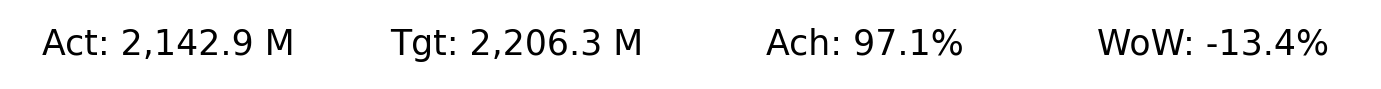

In [75]:
''' Weekly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(wtd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(wtd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

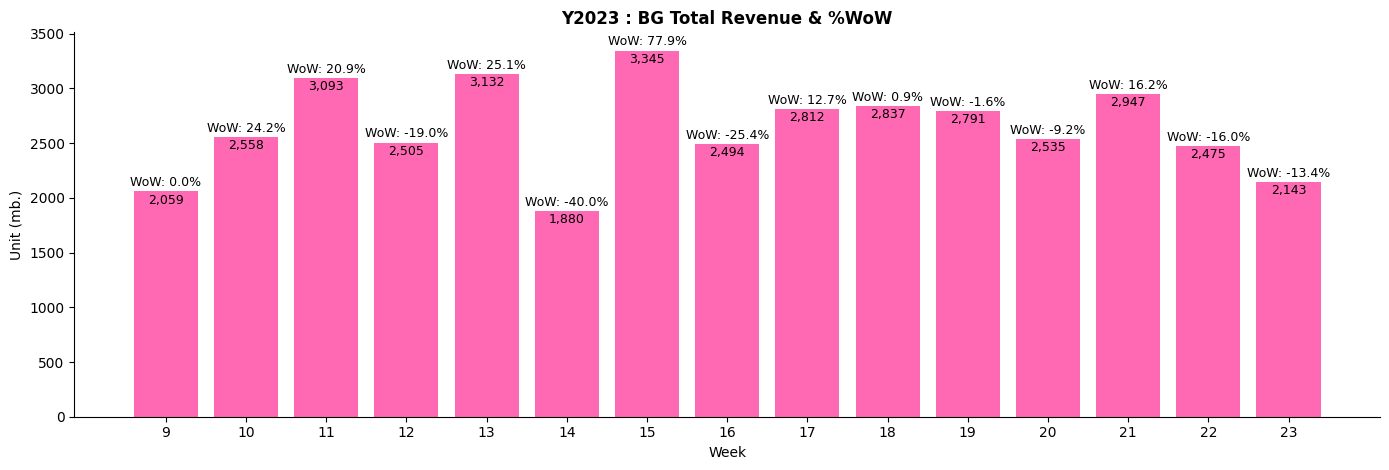

In [76]:
''' Total Revenue & WoW : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Total Revenue & %WoW", weight='bold')
plt.bar(x_wk_axis, y_wk_act, label='Total', color='hotpink')
for i in x_wk_axis:
    plt.annotate(f"WoW: {format(y_wk_wow[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_wk_act[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]-20), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.tight_layout()
plt.show()

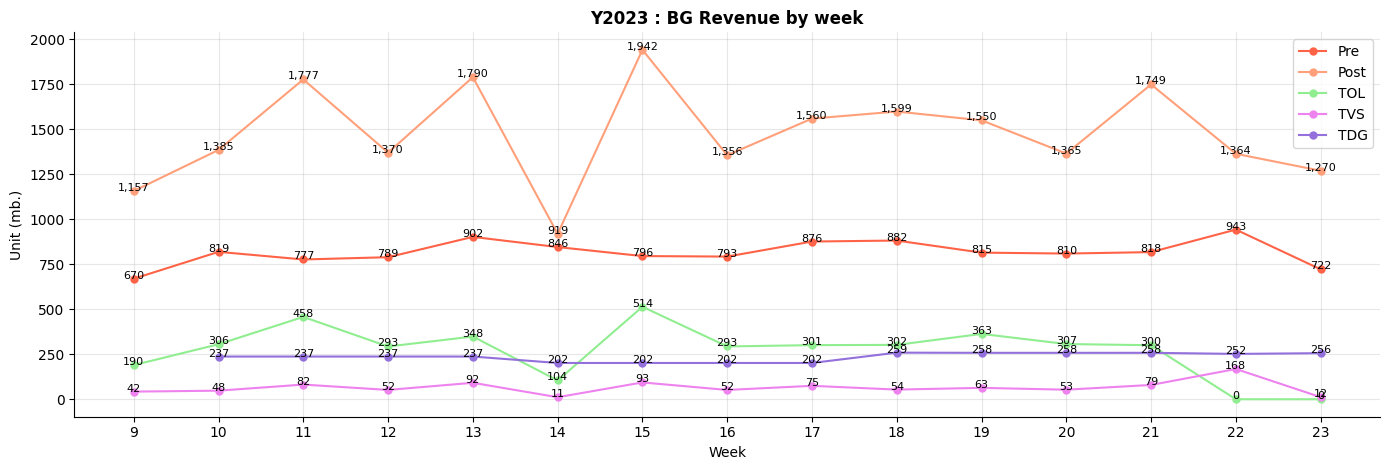

In [77]:
''' Revenue : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Revenue by week", weight='bold')
plt.plot(x_wk_axis, y_wk_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_wk_axis, y_wk_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_wk_axis, y_wk_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_wk_axis, y_wk_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_wk_axis, y_wk_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act_pre[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tol[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tvs[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tdg[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

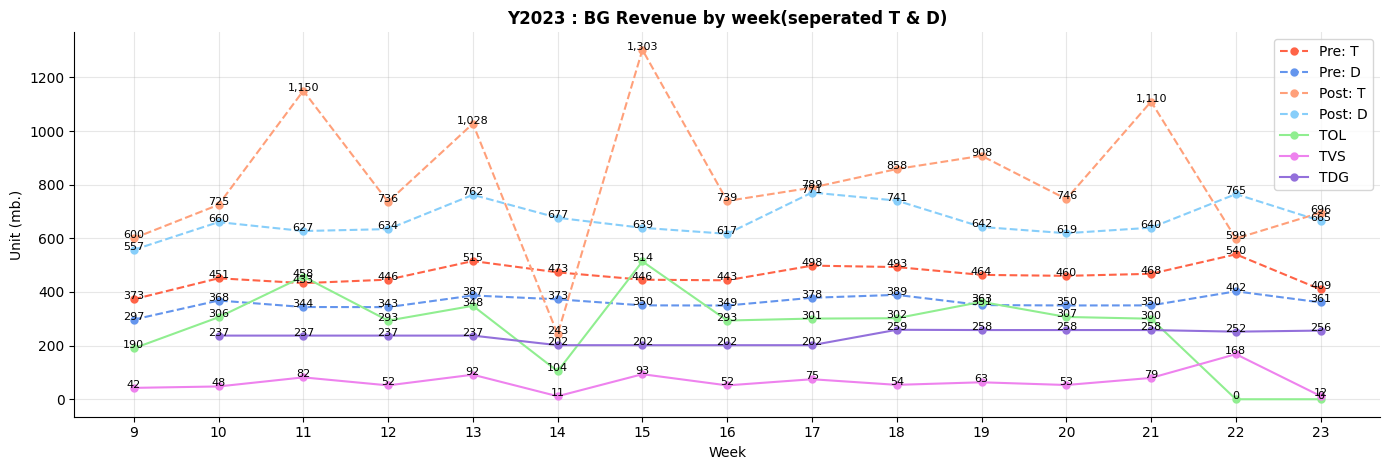

In [78]:
''' Revenue(Mobile separated by TMH, DTAC) : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Revenue by week(seperated T & D)", weight='bold')
plt.plot(x_wk_axis, y_wk_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_wk_axis, y_wk_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_wk_axis, y_wk_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_wk_axis, y_wk_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_wk_axis, y_wk_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_wk_axis, y_wk_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_wk_axis, y_wk_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act_pre_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_pre_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tol[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tvs[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tdg[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ** Daily (MTD)

### DAY : Aggregation

In [79]:
''' Create Dataframe '''

# day_end_of_last_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth]['TM_KEY_DAY'].max()
df_rev_day_curr_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth].reset_index()
df_rev_day_curr_mth.tail()

index TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR  \
METRIC_NAME                                                              
6              98   20230607   2023023     202306      20232      2023   
7              99   20230608   2023023     202306      20232      2023   
8             100   20230609   2023023     202306      20232      2023   
9             101   20230610   2023023     202306      20232      2023   
10            102   20230611   2023023     202306      20232      2023   

            MTH_DESC DAY_LABEL    ACT_SNAP             ... %DOD          \
METRIC_NAME                           POST  POST_DTAC  ...  TDG TOL TVS   
6               June         7   94.544733  94.544733  ...  0.0 NaN NaN   
7               June         8   95.178246  95.178246  ...  0.0 NaN NaN   
8               June         9   95.268799  95.268799  ...  0.0 NaN NaN   
9               June        10  559.373631  94.435576  ...  0.0 NaN NaN   
10              June        11         NaN  90.600177  ...  0.0 NaN NaN   

                 ACT_BG      TGT_BG  %ACHV_BG     GAP_BG LAST_ACT_BG  \
METRIC_NAME                                                            
6            213.157441  219.844329  0.969584  -6.686888  467.171610   
7            212.775798  216.784770  0.981507  -4.008971  213.157441   
8            216.977813  214.181772  1.013055   2.796042  212.775798   
9            676.841589  713.667383  0.948399 -36.825794  216.977813   
10           139.317080  147.119185  0.946967  -7.802105  676.841589   

                DIFF_BG   %DOD_BG  
METRIC_NAME                        
6           -254.014169 -0.543728  
7             -0.381643 -0.001790  
8              4.202015  0.019749  
9            459.863776  2.119405  
10          -537.524509 -0.794166  

[5 rows x 78 columns]

In [80]:
''' Day Chart Values '''

x_day = df_rev_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' Actual '''
y_day_act = df_rev_day_curr_mth['ACT_BG']
y_day_act_post = df_rev_day_curr_mth['ACT_SNAP']['POST']
y_day_act_post_dtac = df_rev_day_curr_mth['ACT_SNAP']['POST_DTAC']
y_day_act_post_tmh = df_rev_day_curr_mth['ACT_SNAP']['POST_TMH']
y_day_act_pre = df_rev_day_curr_mth['ACT_SNAP']['PRE']
y_day_act_pre_dtac = df_rev_day_curr_mth['ACT_SNAP']['PRE_DTAC']
y_day_act_pre_tmh = df_rev_day_curr_mth['ACT_SNAP']['PRE_TMH']
y_day_act_tdg = df_rev_day_curr_mth['ACT_SNAP']['TDG']
y_day_act_tol = df_rev_day_curr_mth['ACT_SNAP']['TOL']
y_day_act_tvs = df_rev_day_curr_mth['ACT_SNAP']['TVS']

''' Target '''
y_day_tgt = df_rev_day_curr_mth['TGT_BG']
y_day_tgt_post = df_rev_day_curr_mth['TGT_SNAP']['POST']
y_day_tgt_post_dtac = df_rev_day_curr_mth['TGT_SNAP']['POST_DTAC']
y_day_tgt_post_tmh = df_rev_day_curr_mth['TGT_SNAP']['POST_TMH']
y_day_tgt_pre = df_rev_day_curr_mth['TGT_SNAP']['PRE']
y_day_tgt_pre_dtac = df_rev_day_curr_mth['TGT_SNAP']['PRE_DTAC']
y_day_tgt_pre_tmh = df_rev_day_curr_mth['TGT_SNAP']['PRE_TMH']
y_day_tgt_tdg = df_rev_day_curr_mth['TGT_SNAP']['TDG']
y_day_tgt_tol = df_rev_day_curr_mth['TGT_SNAP']['TOL']
y_day_tgt_tvs = df_rev_day_curr_mth['TGT_SNAP']['TVS']

''' % Achievement '''
y_day_achv = df_rev_day_curr_mth['%ACHV_BG']
y_day_achv_post = df_rev_day_curr_mth['%ACHV']['POST']
y_day_achv_post_dtac = df_rev_day_curr_mth['%ACHV']['POST_DTAC']
y_day_achv_post_tmh = df_rev_day_curr_mth['%ACHV']['POST_TMH']
y_day_achv_pre = df_rev_day_curr_mth['%ACHV']['PRE']
y_day_achv_pre_dtac = df_rev_day_curr_mth['%ACHV']['PRE_DTAC']
y_day_achv_pre_tmh = df_rev_day_curr_mth['%ACHV']['PRE_TMH']
y_day_achv_tdg = df_rev_day_curr_mth['%ACHV']['TDG']
y_day_achv_tol = df_rev_day_curr_mth['%ACHV']['TOL']
y_day_achv_tvs = df_rev_day_curr_mth['%ACHV']['TVS']

''' Gap '''
y_day_gap = df_rev_day_curr_mth['GAP_BG']
y_day_gap_post = df_rev_day_curr_mth['GAP']['POST']
y_day_gap_post_dtac = df_rev_day_curr_mth['GAP']['POST_DTAC']
y_day_gap_post_tmh = df_rev_day_curr_mth['GAP']['POST_TMH']
y_day_gap_pre = df_rev_day_curr_mth['GAP']['PRE']
y_day_gap_pre_dtac = df_rev_day_curr_mth['GAP']['PRE_DTAC']
y_day_gap_pre_tmh = df_rev_day_curr_mth['GAP']['PRE_TMH']
y_day_gap_tdg = df_rev_day_curr_mth['GAP']['TDG']
y_day_gap_tol = df_rev_day_curr_mth['GAP']['TOL']
y_day_gap_tvs = df_rev_day_curr_mth['GAP']['TVS']

''' Last Actual '''
y_day_last_act = df_rev_day_curr_mth['LAST_ACT_BG']
y_day_last_act_post = df_rev_day_curr_mth['LAST_ACT']['POST']
y_day_last_act_post_dtac = df_rev_day_curr_mth['LAST_ACT']['POST_DTAC']
y_day_last_act_post_tmh = df_rev_day_curr_mth['LAST_ACT']['POST_TMH']
y_day_last_act_pre = df_rev_day_curr_mth['LAST_ACT']['PRE']
y_day_last_act_pre_dtac = df_rev_day_curr_mth['LAST_ACT']['PRE_DTAC']
y_day_last_act_pre_tmh = df_rev_day_curr_mth['LAST_ACT']['PRE_TMH']
y_day_last_act_tdg = df_rev_day_curr_mth['LAST_ACT']['TDG']
y_day_last_act_tol = df_rev_day_curr_mth['LAST_ACT']['TOL']
y_day_last_act_tvs = df_rev_day_curr_mth['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_day_diff = df_rev_day_curr_mth['DIFF_BG']
y_day_diff_post = df_rev_day_curr_mth['DIFF']['POST']
y_day_diff_post_dtac = df_rev_day_curr_mth['DIFF']['POST_DTAC']
y_day_diff_post_tmh = df_rev_day_curr_mth['DIFF']['POST_TMH']
y_day_diff_pre = df_rev_day_curr_mth['DIFF']['PRE']
y_day_diff_pre_dtac = df_rev_day_curr_mth['DIFF']['PRE_DTAC']
y_day_diff_pre_tmh = df_rev_day_curr_mth['DIFF']['PRE_TMH']
y_day_diff_tdg = df_rev_day_curr_mth['DIFF']['TDG']
y_day_diff_tol = df_rev_day_curr_mth['DIFF']['TOL']
y_day_diff_tvs = df_rev_day_curr_mth['DIFF']['TVS']

''' % DOD '''
y_day_dod = df_rev_day_curr_mth['%DOD_BG']
y_day_dod_post = df_rev_day_curr_mth['%DOD']['POST']
y_day_dod_post_dtac = df_rev_day_curr_mth['%DOD']['POST_DTAC']
y_day_dod_post_tmh = df_rev_day_curr_mth['%DOD']['POST_TMH']
y_day_dod_pre = df_rev_day_curr_mth['%DOD']['PRE']
y_day_dod_pre_dtac = df_rev_day_curr_mth['%DOD']['PRE_DTAC']
y_day_dod_pre_tmh = df_rev_day_curr_mth['%DOD']['PRE_TMH']
y_day_dod_tdg = df_rev_day_curr_mth['%DOD']['TDG']
y_day_dod_tol = df_rev_day_curr_mth['%DOD']['TOL']
y_day_dod_tvs = df_rev_day_curr_mth['%DOD']['TVS']

### DAY : Business Growth Revenue Summary

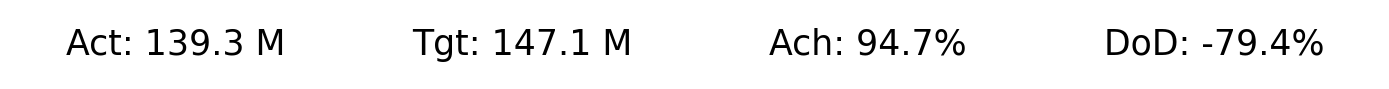

In [81]:
''' Daily Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(y_day_act.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(y_day_tgt.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(y_day_achv.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(y_day_dod.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

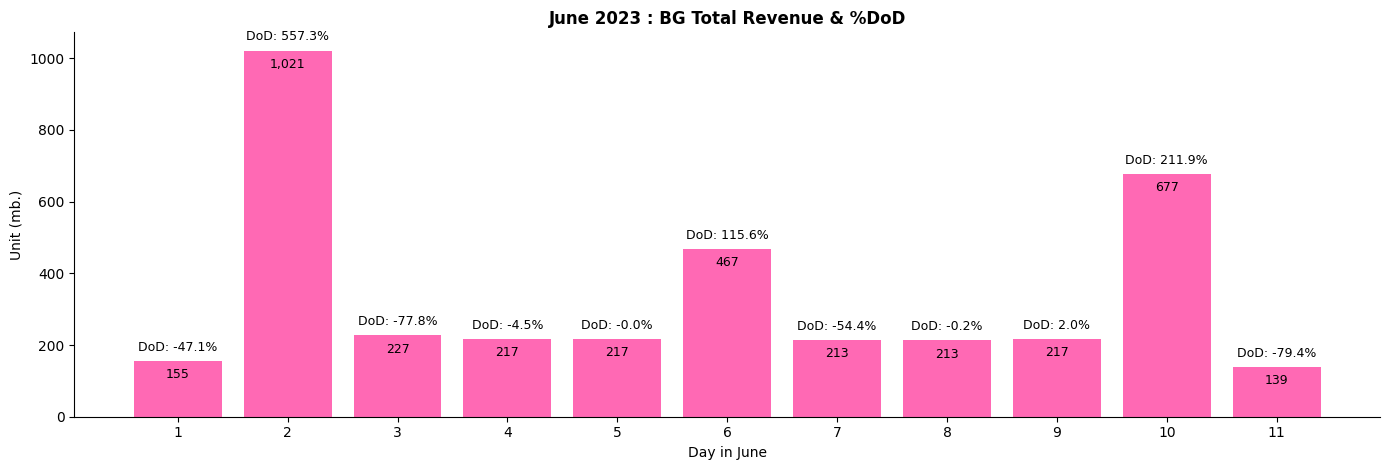

In [82]:
''' Total Revenue & DoD : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : BG Total Revenue & %DoD", fontdict={'fontweight': 'bold'})
plt.bar(x_day_axis, y_day_act, label='Total', color='hotpink')
for i in x_day_axis:
    plt.annotate(f"DoD: {format(y_day_dod[i],',.1%')}", xy=(x_day_axis[i], y_day_act[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_act[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]-20), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day in {curr_mth_desc}')
plt.xticks(x_day_axis, x_day)
plt.tight_layout()
plt.show()

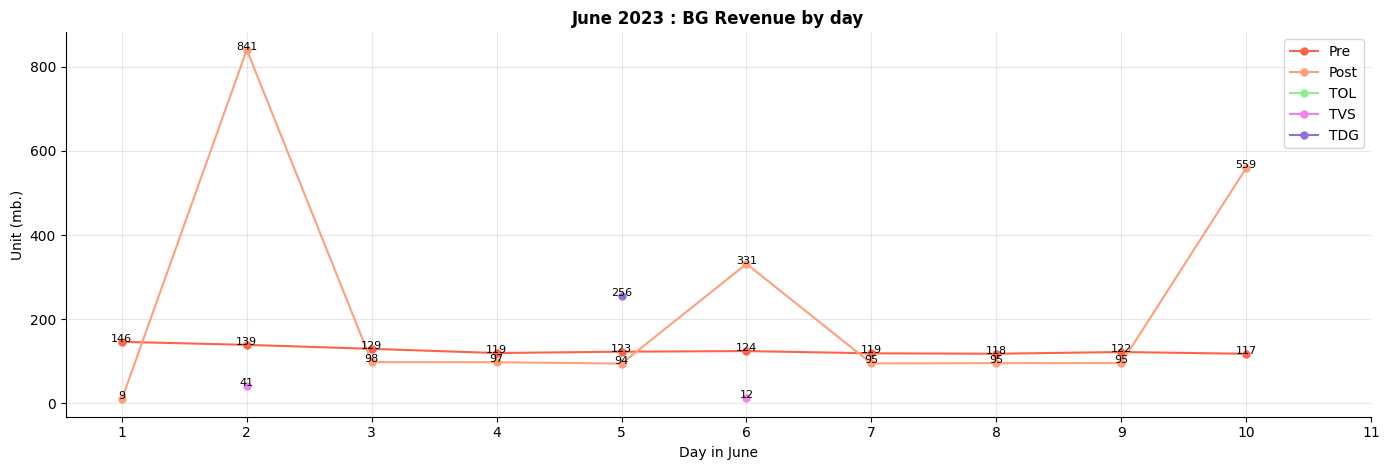

In [83]:
''' Revenue : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : BG Revenue by day", fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_day_axis, y_day_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_day_axis, y_day_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_day_axis, y_day_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_day_axis, y_day_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_day_axis:
    plt.annotate(format(y_day_act_pre[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post[i],',.0f'), xy=(x_day_axis[i], y_day_act_post[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tol[i],',.0f'), xy=(x_day_axis[i], y_day_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tvs[i],',.0f'), xy=(x_day_axis[i], y_day_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tdg[i],',.0f'), xy=(x_day_axis[i], y_day_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day in {curr_mth_desc}')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

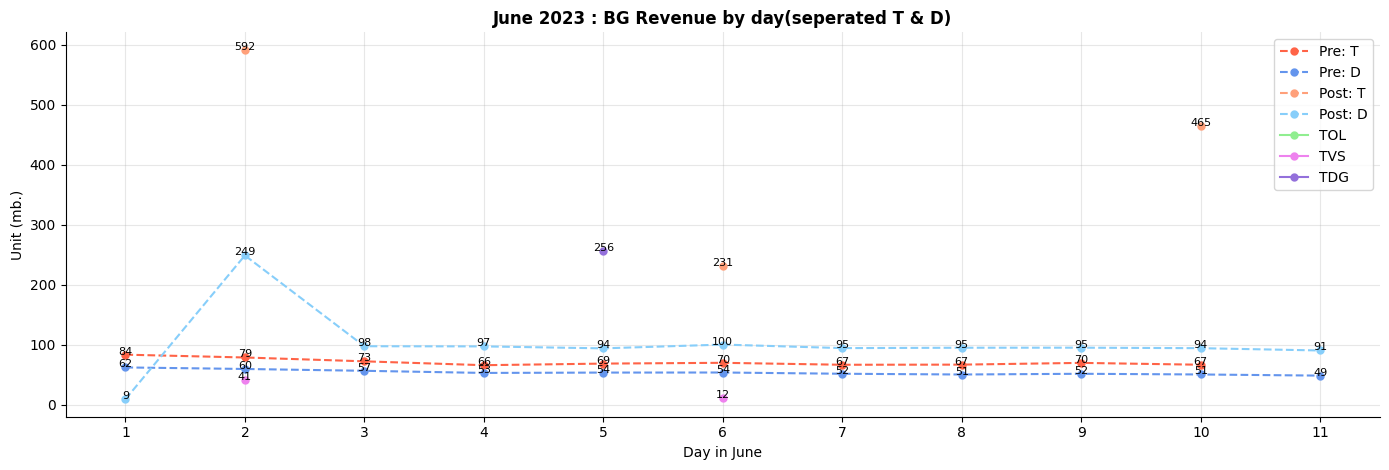

In [84]:
''' Revenue(Mobile separated by TMH, DTAC) : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : BG Revenue by day(seperated T & D)", fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_day_axis, y_day_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_day_axis, y_day_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_day_axis, y_day_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_day_axis, y_day_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_day_axis, y_day_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_day_axis, y_day_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_day_axis:
    plt.annotate(format(y_day_act_pre_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_pre_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tol[i],',.0f'), xy=(x_day_axis[i], y_day_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tvs[i],',.0f'), xy=(x_day_axis[i], y_day_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tdg[i],',.0f'), xy=(x_day_axis[i], y_day_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day in {curr_mth_desc}')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Generate Output Data

In [85]:
# df_rev_day.to_excel('../data/interim/df_rev_day.xlsx', index=False)
# df_rev_yr.to_excel('../data/interim/df_rev_yr.xlsx', index=False)
# df_rev_mth.to_excel('../data/interim/df_rev_mth.xlsx', index=False)
# df_rev_wk.to_excel('../data/interim/df_rev_wk.xlsx', index=False)